In [1]:
library(ROSE)
library(ggplot2)
library(randomForest)
library(caret)
library(dplyr)
library(e1071)
library(Boruta)
mat.students=read.csv("student-mat.csv")

Loaded ROSE 0.0-3

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Loading required package: lattice

Attaching package: 'dplyr'

The following object is masked from 'package:randomForest':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ranger

Attaching package: 'ranger'

The following object is masked from 'package:randomForest':

    importance



In [11]:
mat.students$subject <- "m"
# portuguesse students
por.students=read.csv("student-por.csv")
por.students$subject <- "p"

In [12]:
# combine both datasets
students <- rbind(mat.students,por.students)
nrow_i <- nrow(students)

In [13]:
# standarizing column names
colnames(students) <- tolower(colnames(students))

In [14]:
# columns which define duplicated students
uniq.key.cols <- c("school","sex","age","address","famsize","pstatus","medu",
                   "fedu","mjob","fjob","reason","nursery","internet")

In [15]:
# get duplicated rows of the combined dataset
duplicated.rows <- duplicated(students[,uniq.key.cols])

In [28]:
#do we have missing data?
nrow(students) - sum(complete.cases(students))

[1] 0

In [29]:
#do we have near zero variance predictors?
nzv <- nearZeroVar(students, saveMetrics= TRUE)
# number of predictors with near zero variance
nzv %>% filter(nzv == TRUE) %>% nrow()

[1] 0

In [16]:
# subset of duplicated students
students.duplicated <- students[duplicated.rows,]
add.duplicates.subject <- function(duplicated){
  # the search for duplicated data in "students" data frame
  rows <- students$school == duplicated$school &
    students$sex == duplicated$sex &
    students$age == duplicated$age &
    students$address == duplicated$address &
    students$famsize == duplicated$famsize &
    students$pstatus == duplicated$pstatus &
    students$medu == duplicated$medu &
    students$fedu == duplicated$fedu &
    students$mjob == duplicated$mjob &
    students$reason == duplicated$reason &
    students$nursery == duplicated$nursery &
    students$internet == duplicated$internet
  # change subject to both math and portuguesse
  students[rows,"subject"] <<- "m.p"
}

In [17]:
# apply the above algorithm to every duplicated row
for(n in 1:nrow(students.duplicated)){
  add.duplicates.subject(students.duplicated[n,])
}

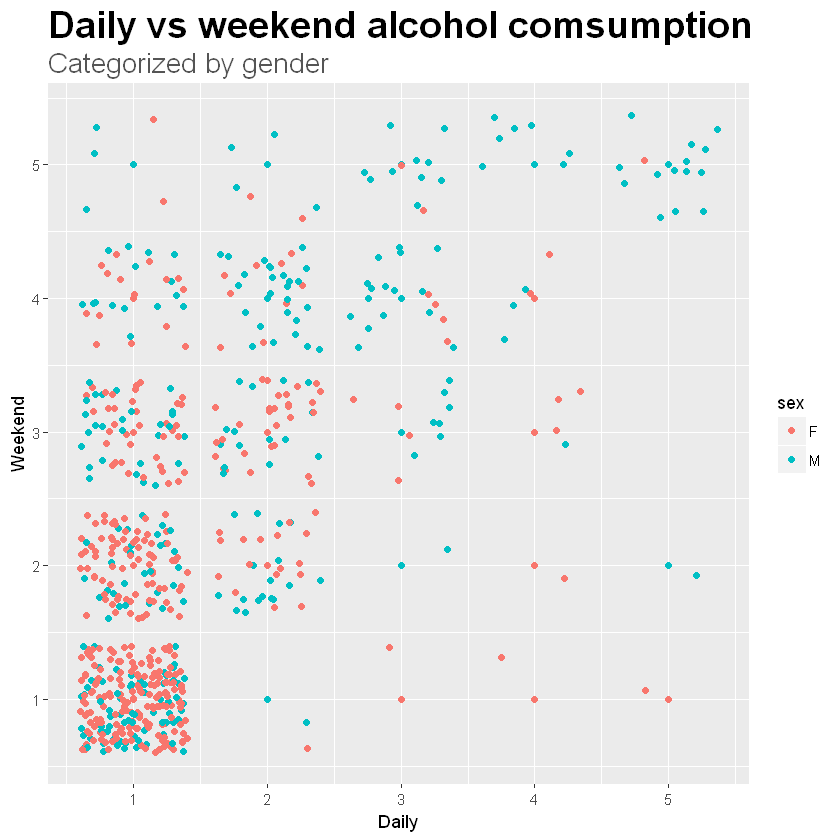


	Welch Two Sample t-test

data:  students[students$school == "MS", "dalc"] and students[students$school == "GP", "dalc"]
t = 1.6241, df = 422.34, p-value = 0.1051
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02668415  0.28046376
sample estimates:
mean of x mean of y 
 1.587719  1.460829 



	Welch Two Sample t-test

data:  students[students$school == "MS", "walc"] and students[students$school == "GP", "walc"]
t = 0.73926, df = 469.15, p-value = 0.4601
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1286246  0.2837705
sample estimates:
mean of x mean of y 
 2.333333  2.255760 



	Welch Two Sample t-test

data:  students[students$sex == "M", "dalc"] and students[students$sex == "F", "dalc"]
t = 7.1398, df = 395.06, p-value = 4.518e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3969006 0.6985368
sample estimates:
mean of x mean of y 
 1.827206  1.279487 



	Welch Two Sample t-test

data:  students[students$sex == "M", "walc"] and students[students$sex == "F", "walc"]
t = 8.509, df = 472.83, p-value = 2.335e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.6631188 1.0613533
sample estimates:
mean of x mean of y 
 2.790441  1.928205 


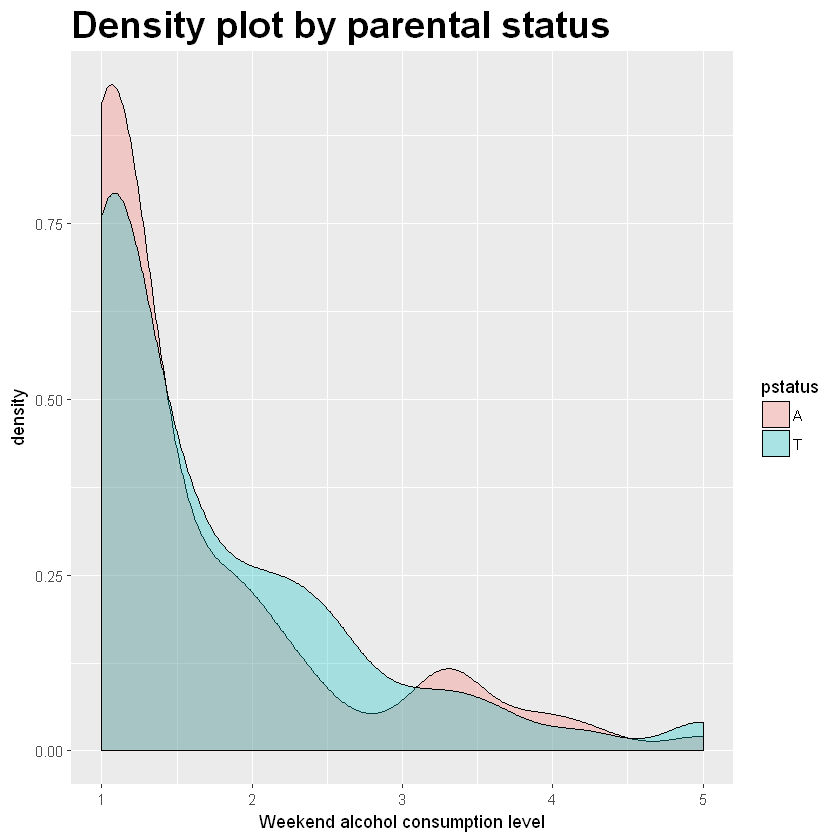

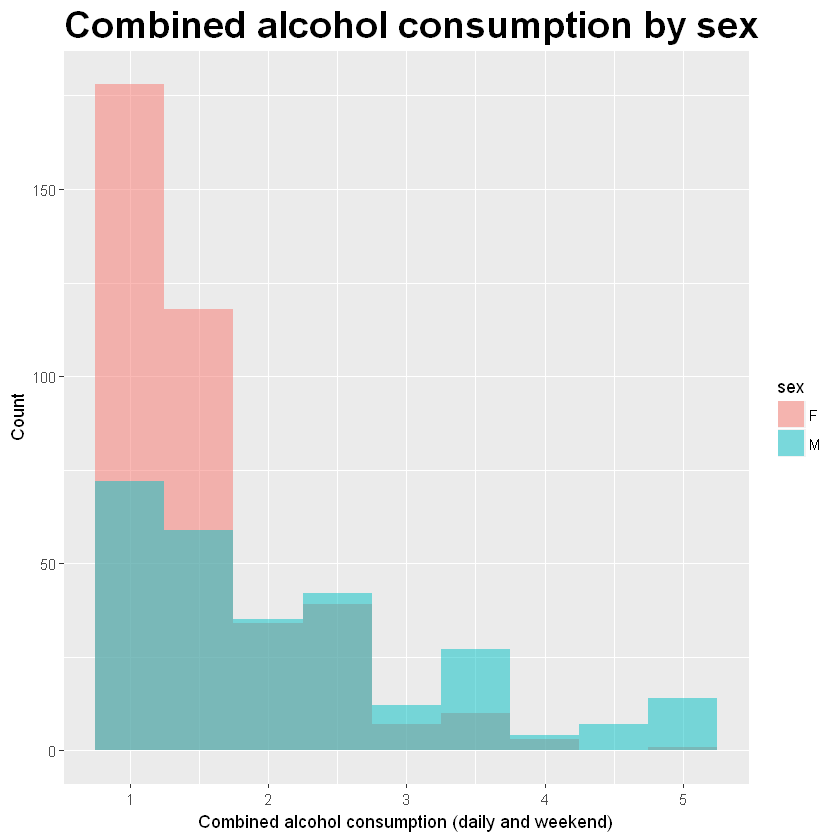


	Welch Two Sample t-test

data:  pappart.acl and ptogether.acl
t = -1.1959, df = 108.47, p-value = 0.2343
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.34133366  0.08443635
sample estimates:
mean of x mean of y 
 1.614458  1.742906 


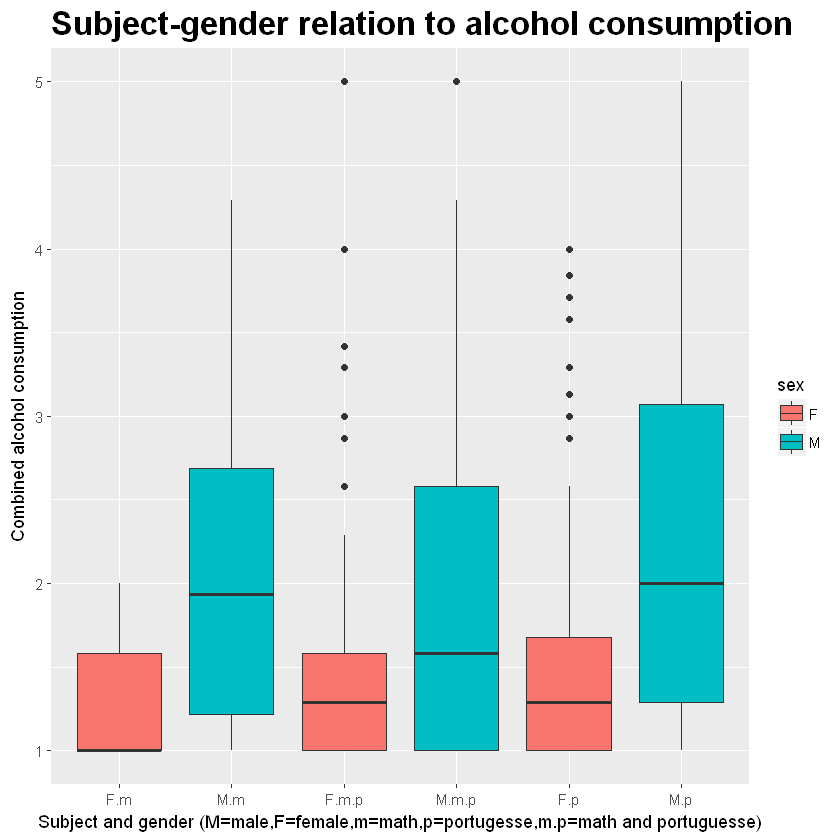

In [18]:
# new remove duplicated
students <- students[!duplicated.rows,]
## Statistical data analysis
### Do students drink more on weekends?
tt <- t.test(students$walc,students$dalc,paired = TRUE,alternative = "greater")
### Visualization 
gg <- ggplot(data=students,aes(x=dalc,y=walc,color=sex))
gg <- gg + geom_point()
gg <- gg + geom_jitter()
gg <- gg + labs(x="Daily",y="Weekend")
gg <- gg + ggtitle("Daily vs weekend alcohol comsumption",
                   subtitle = "Categorized by gender")
gg <- gg + theme(plot.title = element_text(size=22, face="bold"))
gg <- gg + theme(plot.subtitle = element_text(size=17,color = "#555555"))
gg

### Does parent's cohabitation status have an effect on alcohol comsumption? 

# subset of students with parents living together
ptogether <- students[students$pstatus == "T",]
# combined alcohol consumption
ptogether.acl <- (2/7)*ptogether$walc + (5/7)*ptogether$dalc
# subset of students with parents living appart
pappart <- students[students$pstatus == "A",]
# combined alcohol consumption
pappart.acl <- (2/7)*pappart$walc + (5/7)*pappart$dalc

ggplot(students,aes(x=(2/7)*walc+(5/7)*dalc, fill=pstatus)) + 
  geom_density(alpha=.3) +
  ggtitle(label = "Density plot by parental status") +
  labs(x="Weekend alcohol consumption level") +
  theme(plot.title = element_text(size=22, face="bold"))

### Are students from both schools different?

# daily
t.test(students[students$school=="MS","dalc"],
       students[students$school=="GP","dalc"],
       paired = FALSE)
# weekends
t.test(students[students$school=="MS","walc"],
       students[students$school=="GP","walc"],
       paired = FALSE)
### Is there are difference between males and females
# daily
t.test(students[students$sex=="M","dalc"],
       students[students$sex=="F","dalc"],
       paired = FALSE)
# weekends
t.test(students[students$sex=="M","walc"],
       students[students$sex=="F","walc"],
       paired = FALSE)

ggplot(students,aes(x=(2/7)*walc+(5/7)*dalc, fill=sex)) + 
  geom_histogram(binwidth=.5,position="identity",alpha=0.5) +
  ggtitle("Combined alcohol consumption by sex") +
  labs(x="Combined alcohol consumption (daily and weekend)",y="Count") +
  theme(plot.title = element_text(size=22, face="bold"))

## Is student's subject and gender related to alcohol consumption habits?
ggplot(data = students, aes(x=interaction(sex,subject),y=0.29*walc+0.71*dalc)) +
  geom_boxplot(aes(fill=sex)) +
  ggtitle("Subject-gender relation to alcohol consumption") +
  theme(plot.title = element_text(size=20, face="bold")) +
  xlab("Subject and gender (M=male,F=female,m=math,p=portugesse,m.p=math and portuguesse)") +
  ylab("Combined alcohol consumption")


# two sample unpaired t-test
tt <- t.test(pappart.acl,ptogether.acl,paired = FALSE)
tt

In [ ]:
#Are students from both school differnt?
#

In [19]:
# subject as factor
students$subject <- as.factor(students$subject)
students$Alc <- (students$walc *2 + students$dalc * 5) / 7
students$Alc
drinkr <- function(x){
  if (x >= 3 ){
    return(x = 1)
  } else{
    return(x = 0)
  }
}
students$Alc <- sapply(students$Alc, drinkr)
students$Alc <- as.factor(students$Alc)
nrow_f <-nrow(students)
# number of duplicates removed
nduplicates <- nrow_i - nrow_f

[1] 1.000000 1.000000 2.285714 1.000000 1.285714 1.285714 1.000000 1.000000
  [9] 1.000000 1.000000 1.285714 1.000000 1.571429 1.285714 1.000000 1.285714
 [17] 1.285714 1.000000 2.571429 1.571429 1.000000 1.000000 1.571429 2.571429
 [25] 1.000000 1.571429 1.285714 2.571429 1.000000 5.000000 3.285714 1.000000
 [33] 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 [41] 1.285714 2.571429 1.000000 1.000000 2.000000 1.000000 1.857143 1.000000
 [49] 2.000000 1.000000 2.285714 1.000000 3.285714 2.285714 4.000000 1.000000
 [57] 1.000000 1.000000 1.000000 1.000000 2.285714 5.000000 1.000000 2.571429
 [65] 2.571429 1.285714 5.000000 1.285714 1.571429 2.285714 1.000000 1.000000
 [73] 2.571429 2.000000 2.571429 2.285714 1.000000 1.571429 1.000000 1.285714
 [81] 1.571429 1.285714 1.000000 1.571429 2.285714 2.285714 1.285714 1.571429
 [89] 1.000000 3.571429 1.571429 1.571429 2.285714 1.000000 1.000000 1.000000
 [97] 1.000000 1.000000 1.285714 1.000000 5.000000 1.000000 1.000000 1.000000
[105] 1.000000 1.000000 1.000000 1.000000 3.571429 1.000000 1.000000 1.000000
[113] 1.000000 1.000000 1.000000 1.285714 1.000000 1.000000 1.857143 1.285714
[121] 1.285714 1.285714 1.285714 1.857143 1.000000 2.714286 1.000000 1.000000
[129] 1.285714 2.857143 2.000000 1.285714 1.571429 1.857143 1.000000 1.000000
[137] 2.571429 1.000000 1.571429 1.000000 1.000000 2.000000 1.000000 3.000000
[145] 1.285714 1.000000 1.000000 2.857143 2.857143 3.571429 2.285714 1.000000
[153] 1.000000 1.000000 3.000000 2.142857 1.285714 4.000000 2.000000 1.857143
[161] 2.571429 1.857143 2.142857 1.000000 2.571429 1.000000 1.000000 1.000000
[169] 2.571429 1.000000 1.571429 1.000000 1.000000 4.000000 1.857143 1.857143
[177] 3.285714 1.000000 2.285714 2.285714 2.285714 1.285714 2.285714 1.285714
[185] 1.285714 1.571429 2.142857 1.000000 1.000000 4.285714 3.285714 1.000000
[193] 1.000000 1.285714 3.571429 2.285714 1.285714 2.142857 1.571429 1.571429
[201] 1.285714 1.000000 3.285714 2.000000 1.000000 1.857143 1.000000 1.285714
[209] 4.285714 1.000000 2.571429 1.285714 1.571429 2.571429 2.571429 1.857143
[217] 1.000000 1.285714 1.000000 1.000000 5.000000 1.000000 1.000000 1.571429
[225] 1.571429 4.285714 1.285714 1.285714 1.000000 1.571429 2.571429 1.000000
[233] 1.571429 5.000000 1.000000 1.000000 3.571429 1.857143 2.285714 1.000000
[241] 1.285714 1.000000 1.000000 1.000000 5.000000 1.571429 2.571429 2.571429
[249] 1.571429 2.857143 1.571429 2.571429 1.285714 1.000000 1.000000 1.285714
[257] 1.000000 1.571429 1.000000 1.000000 1.000000 1.000000 3.285714 3.285714
[265] 2.000000 1.571429 1.285714 3.000000 1.571429 1.000000 2.000000 1.000000
[273] 2.285714 1.000000 1.857143 1.000000 1.285714 2.571429 3.285714 1.000000
[281] 1.000000 1.285714 1.285714 1.285714 1.000000 1.571429 1.000000 1.857143
[289] 1.285714 1.000000 1.000000 1.000000 1.571429 2.285714 1.285714 1.000000
[297] 2.000000 1.000000 2.000000 1.000000 1.285714 1.000000 1.000000 1.000000
[305] 1.000000 1.285714 1.571429 2.000000 1.000000 2.000000 1.285714 1.000000
[313] 1.000000 1.285714 1.000000 2.857143 3.000000 1.285714 1.000000 2.000000
[321] 2.285714 2.285714 2.000000 3.571429 5.000000 1.571429 1.285714 2.571429
[329] 1.000000 1.000000 1.000000 1.000000 1.571429 1.285714 2.285714 1.000000
[337] 2.285714 1.571429 1.571429 1.285714 1.285714 2.285714 1.285714 2.285714
[345] 1.571429 5.000000 3.000000 2.285714 2.285714 3.000000 1.571429 1.000000
[353] 1.285714 1.285714 1.285714 1.000000 1.857143 2.285714 1.571429 1.000000
[361] 1.285714 2.571429 2.000000 1.285714 1.285714 3.428571 1.000000 2.285714
[369] 1.000000 1.571429 1.000000 1.285714 1.000000 3.285714 1.285714 2.285714
[377] 1.857143 1.571429 1.000000 1.571429 3.714286 1.571429 2.000000 1.285714
[385] 1.000000 1.000000 4.285714 3.285714 3.000000 3.285714 3.000000 2.000000
[393] 1.571429 1.285714 1.000000 1.000000 1.000000 4.285714 3.857143 1.285714
[401] 1.000000 2.285714 1.000000 2.571429 3.571429 1.857143 2.571429 1.857143
[409] 1.000000 1.285714 

In [20]:
# dimension of the dataset
dim(students)
## [1] 662  34
# remove highly correlated columns
# correlation matrix of numeric predictors
numericColumns <- sapply(students, is.numeric)
corMatrix<-cor(students[,numericColumns])
# find highly correlated columns to later remove
highCor <- findCorrelation(corMatrix,cutoff = .90)
(highCorColumns <- dimnames(corMatrix)[[1]][highCor])
students <- students %>%dplyr:: select(-which(names(.) %in% highCorColumns))
set.seed(2017)

[1] 662  35

[1] "g2"

In [21]:
# 75% train - 25% test
train <- sample(1:nrow(students),size = ceiling(0.8*nrow(students)),replace = FALSE)
students.train <- students[train,]
students.test <- students[-train,]

In [22]:
# we will treat walc and dalc as categorical variables
mtry <- sqrt(ncol(students.train))
ntree <- 1000
student.train <- subset(students.train, select = -c(walc, dalc))
prop.table(table(student.train$Alc))
data.rose <- ROSE(Alc ~ ., data = student.train, seed = 1)$data
prop.table(table(data.rose$Alc))


        0         1 
0.8943396 0.1056604 


        0         1 
0.5264151 0.4735849 

In [23]:
#### Feature Slection using Caret package not so good.
set.seed(123)
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
rfe.train <- rfe(student.train[,2:31], student.train[,32], sizes=1:12, rfeControl=control)
predictors(rfe.train)

[1] "sex"

In [24]:
########   Feature Selection using Bortua Package
set.seed(123)
boruta.train <- Boruta(Alc~., data = student.train, doTrace = 2)
print(boruta.train)
getSelectedAttributes(boruta.train, withTentative = T)

 1. run of importance source...
 2. run of importance source...
 3. run of importance source...
 4. run of importance source...
 5. run of importance source...
 6. run of importance source...
 7. run of importance source...
 8. run of importance source...
 9. run of importance source...
 10. run of importance source...
 11. run of importance source...
 12. run of importance source...
After 12 iterations, +4.4 secs: 
 confirmed 1 attribute: sex;
 rejected 9 attributes: activities, famsize, famsup, fjob, health and 4 more;
 still have 21 attributes left.

 13. run of importance source...
 14. run of importance source...
 15. run of importance source...
 16. run of importance source...
After 16 iterations, +5.5 secs: 
 rejected 5 attributes: famrel, mjob, paid, romantic, subject;
 still have 16 attributes left.

 17. run of importance source...
 18. run of importance source...
 19. run of importance source...
 20. run of importance source...
After 20 iterations, +6.5 secs: 
 confirmed 2 a

Boruta performed 99 iterations in 21.08716 secs.
 8 attributes confirmed important: address, failures, g1, g3, goout and
3 more;
 21 attributes confirmed unimportant: activities, age, famrel, famsize,
famsup and 16 more;
 2 tentative attributes left: absences, higher;


[1] "sex"       "address"   "medu"      "studytime" "failures"  "higher"   
 [7] "goout"     "absences"  "g1"        "g3"

In [25]:
###########Random Forest
rf <- randomForest(Alc~.,data = data.rose,mtry=mtry,ntree=ntree)
student.test <- subset(students.test, select = -c(walc,dalc,Alc))
yhat.rf <- predict(rf,student.test)
cmRF <- confusionMatrix(yhat.rf,students.test$Alc)
print(cmRF)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 82  7
         1 28 15
                                         
               Accuracy : 0.7348         
                 95% CI : (0.651, 0.8079)
    No Information Rate : 0.8333         
    P-Value [Acc > NIR] : 0.9985233      
                                         
                  Kappa : 0.3092         
 Mcnemar's Test P-Value : 0.0007232      
                                         
            Sensitivity : 0.7455         
            Specificity : 0.6818         
         Pos Pred Value : 0.9213         
         Neg Pred Value : 0.3488         
             Prevalence : 0.8333         
         Detection Rate : 0.6212         
   Detection Prevalence : 0.6742         
      Balanced Accuracy : 0.7136         
                                         
       'Positive' Class : 0              
                                         


In [26]:
########### SVM
svm_mdl <- svm(Alc~.,data = data.rose)
yhat.svm <- predict(rf,student.test)
cm <- confusionMatrix(yhat.svm,students.test$Alc)
print(cm)
table(yhat.rf,yhat.svm)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 82  7
         1 28 15
                                         
               Accuracy : 0.7348         
                 95% CI : (0.651, 0.8079)
    No Information Rate : 0.8333         
    P-Value [Acc > NIR] : 0.9985233      
                                         
                  Kappa : 0.3092         
 Mcnemar's Test P-Value : 0.0007232      
                                         
            Sensitivity : 0.7455         
            Specificity : 0.6818         
         Pos Pred Value : 0.9213         
         Neg Pred Value : 0.3488         
             Prevalence : 0.8333         
         Detection Rate : 0.6212         
   Detection Prevalence : 0.6742         
      Balanced Accuracy : 0.7136         
                                         
       'Positive' Class : 0              
                                         


       yhat.svm
yhat.rf  0  1
      0 89  0
      1  0 43

In [27]:
######## Logistic regression
log_mdl <- glm(Alc~ ., family = binomial(link = "logit"), data = data.rose)
yhat <- predict(log_mdl,student.test, type = "response")
yhat_log <- ifelse(yhat > 0.5, 1 , 0)
table(yhat.rf,yhat_log)
cmlog <- confusionMatrix(yhat_log,students.test$Alc)
print(cmlog)

       yhat_log
yhat.rf  0  1
      0 64 25
      1  6 37

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 65  5
         1 45 17
                                          
               Accuracy : 0.6212          
                 95% CI : (0.5327, 0.7042)
    No Information Rate : 0.8333          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2105          
 Mcnemar's Test P-Value : 3.479e-08       
                                          
            Sensitivity : 0.5909          
            Specificity : 0.7727          
         Pos Pred Value : 0.9286          
         Neg Pred Value : 0.2742          
             Prevalence : 0.8333          
         Detection Rate : 0.4924          
   Detection Prevalence : 0.5303          
      Balanced Accuracy : 0.6818          
                                          
       'Positive' Class : 0               
                                          
